# Exercise 12.3
Classifying my own handwritten digits

In [1]:
import os
import random

# prevents tensorflow from printing many useless warnings (for presentation purposes)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# scikit-learn throws errors on my machine if loaded after the others.
# It is used to plot confusion matrices
import sklearn


from ex12.utils import (
    load_history,
    save_history,
    optimize_model,
    plot_fits,
    plot_confusion_matrices,
    plot_wrong_predictions,
)
from ex12.models import make_big_cnn, load_best_weights
from global_utils import results_dir

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# progressbar library
from tqdm.notebook import tqdm

random.seed(1)
tf.random.set_seed(1)

# Loading and reshaping the dataset. Reshaping could also be done on-the-fly
# through keras layers or using the tf.Data pipeline, but as long as
# the dataset fits in memory it is faster to preprocess it.
# Reshaping here consists in appending an axis to the tensor, as per requirements of keras' Conv2D layer
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0

# The number of features: 10 digits
n_classes = 10

# Use cached data instead of recomputing
use_cache = True
# Overwrite cached data
overwrite = False

verbosity = 0


The digits are loaded from the folder "digits" using a routine provided by keras.

In [2]:
my_digits = keras.preprocessing.image_dataset_from_directory(
    results_dir("12") / "digits",
    labels="inferred",
    color_mode="grayscale",
    batch_size=10,
    image_size=(28, 28),
    shuffle=False,
    validation_split=0,
).map(
    lambda im, label: (255.0 - im, label)
)  # The image data is inverted to have a black background as in the mnist dataset
# x_eval stores the digits images, y_eval the labels
x_eval = next(my_digits.map(lambda im, _: im).as_numpy_iterator())
y_eval = next(my_digits.map(lambda _, lab: lab).as_numpy_iterator())


Found 10 files belonging to 10 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



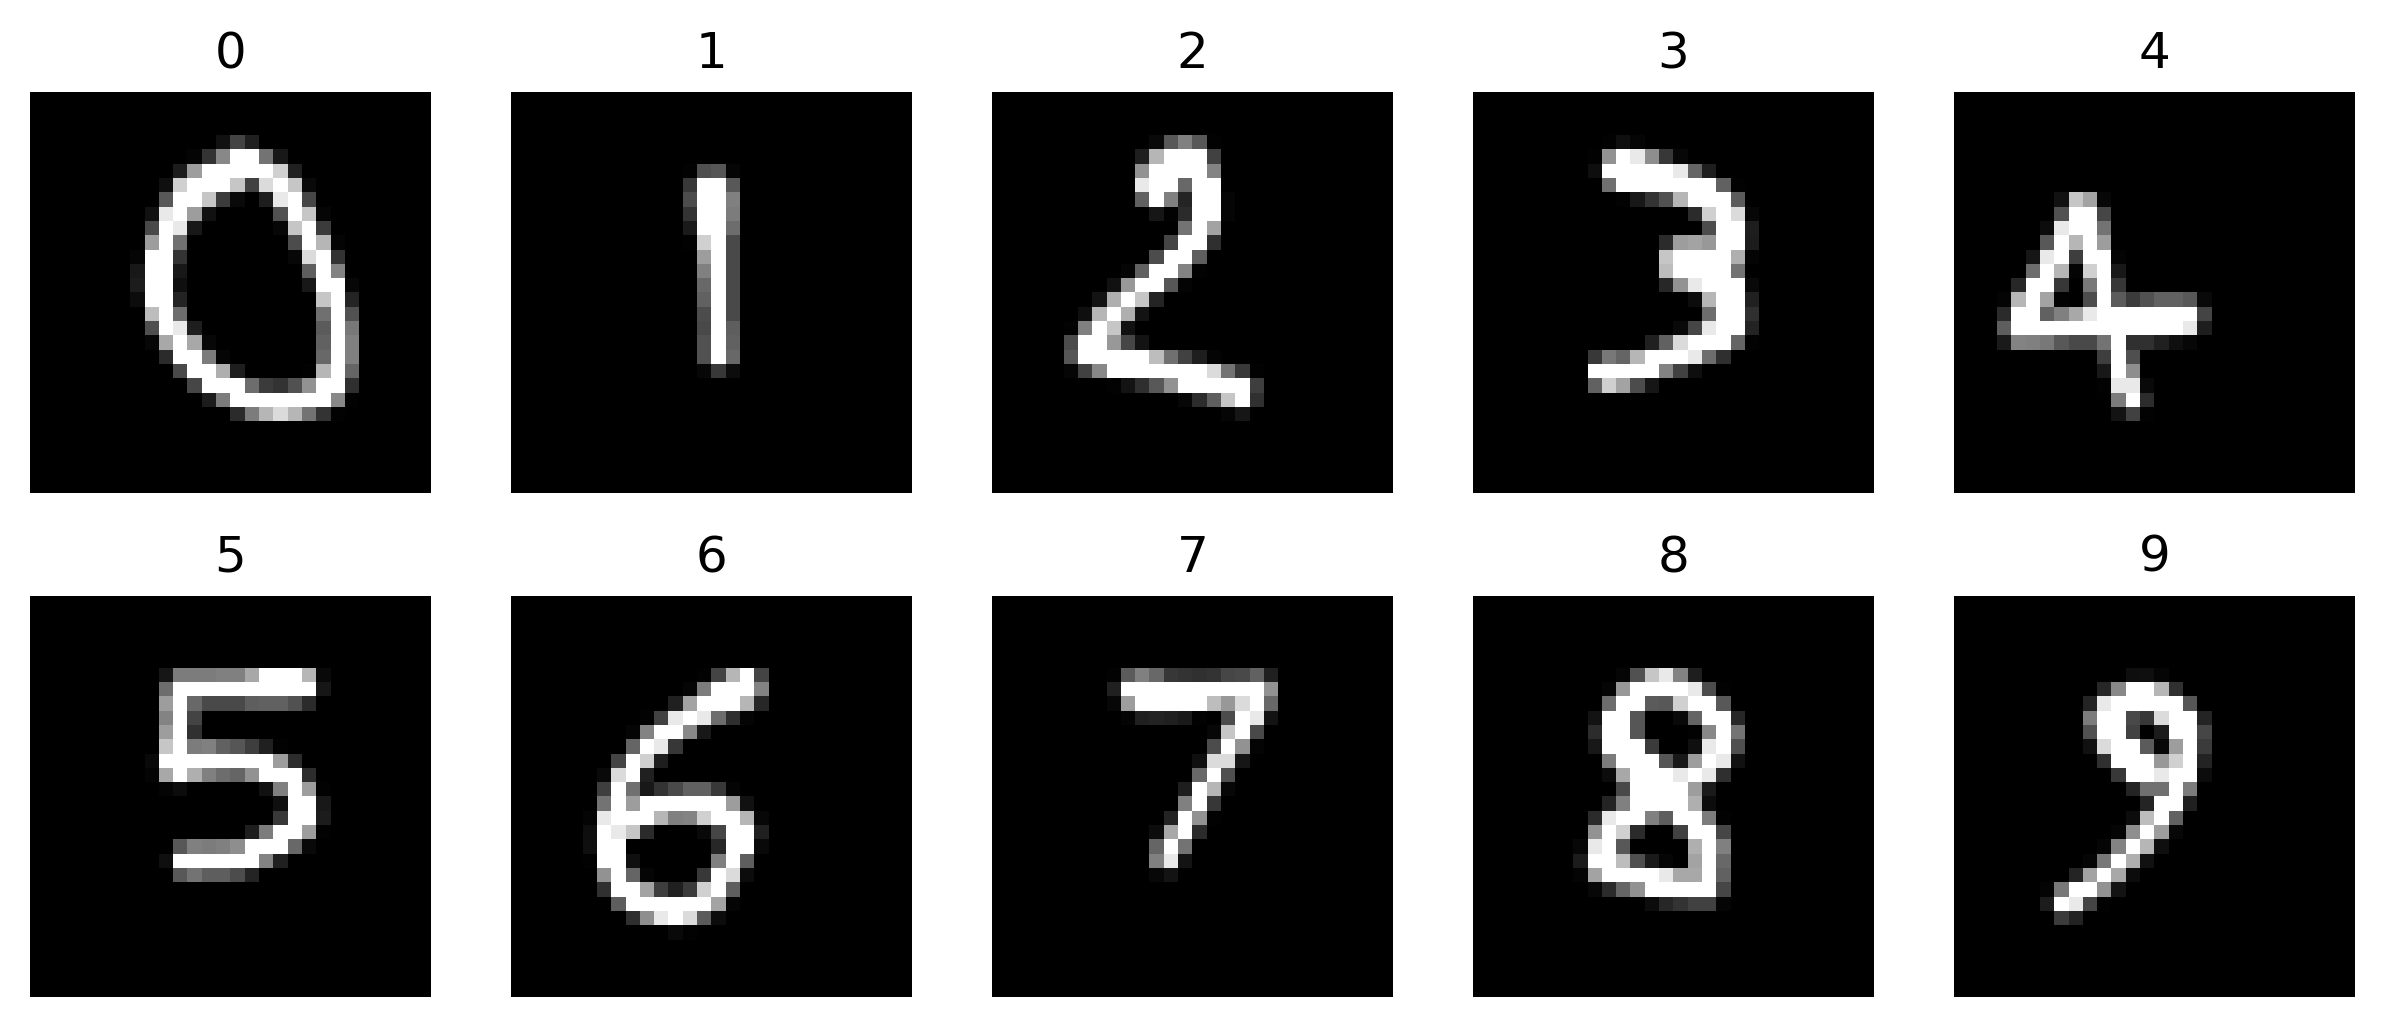

In [3]:
# Plotting the hand-drawn digits
fig, axes = plt.subplots(2, 5, dpi=300, figsize=(10, 4))
for im, lab, ax in zip(x_eval, y_eval, axes.flatten()):
    ax.imshow(im, cmap="gray")
    ax.set_title(f"{lab}")
    ax.set_axis_off()


The "big" CNN trained with ```adam``` and a batch size of 16 will be used, as in exercise 12.2 it performed the best on mnist digits.

In [4]:
model = make_big_cnn(f"adam_16_big_cnn")
if use_cache:
    found = load_best_weights(model, verbose=1)
if not found or not use_cache:
    _ = optimize_model(
        model,
        ((x_train, y_train), (x_test, y_test)),
        "adam",
        16,
        verbose=verbosity,
        max_epochs=15,
    )


adam_16_big_cnn was found


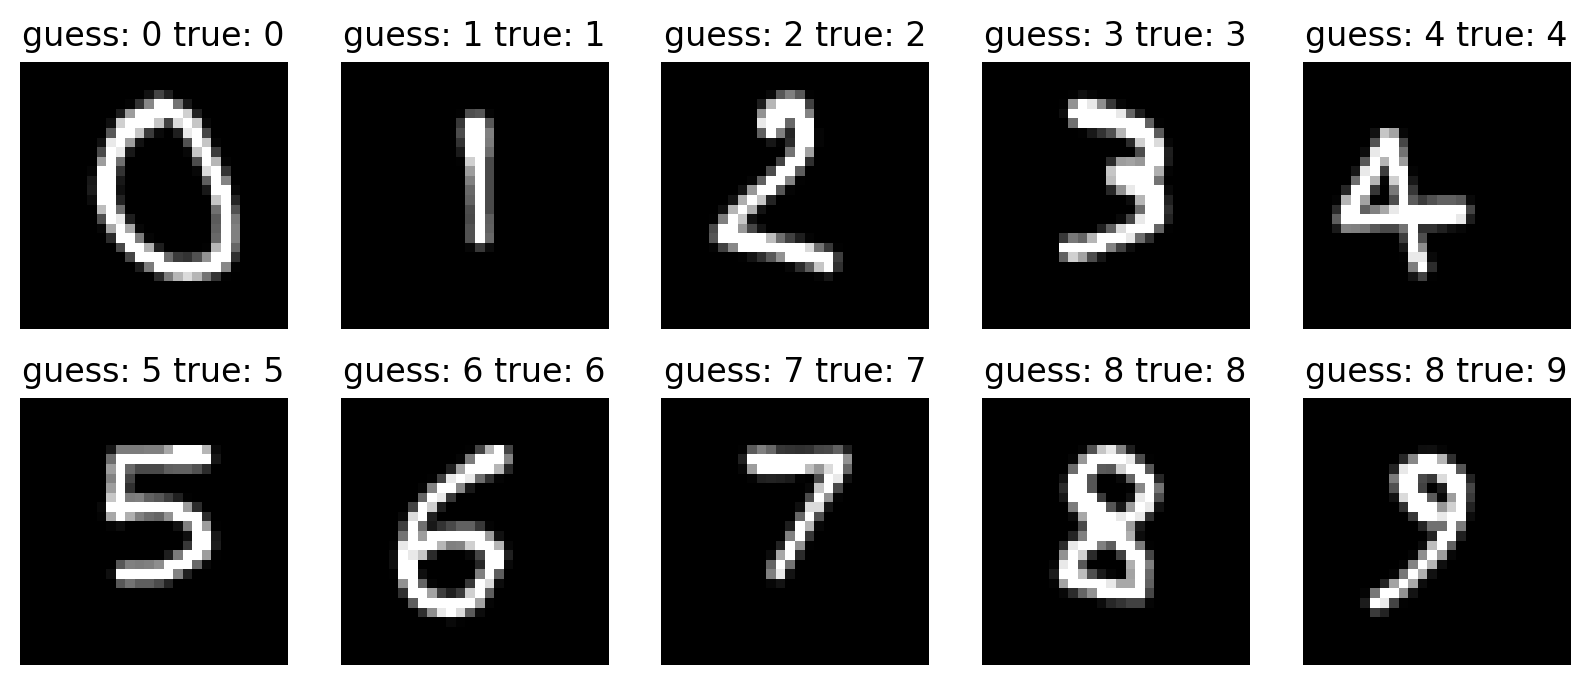

In [5]:
fig, axes = plt.subplots(2, 5, dpi=200, figsize=(10,4))
classifications = np.argmax(model.predict(x_eval, verbose=verbosity), axis=-1)
for img, true_label, classification, ax in zip(x_eval, y_eval, classifications, axes.flatten()):
    ax.imshow(img, cmap="gray")
    ax.set_title(f"guess: {classification} true: {true_label}")
    ax.set_axis_off()


The model gets right almost every digit except 9, despite it being pretty easy to classify as a human.